<a href="https://colab.research.google.com/github/bendevishal/Image_colorization_DL/blob/main/Image_Colorization_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Colour: Image Colorization Using Deep Autoencoders

## Project Overview
This project implements an automatic image colorization system using deep autoencoders. The model takes grayscale images as input and produces colorized versions by learning the mapping between grayscale and color images through a deep learning architecture.

### Key Objectives:
- Build an encoder-decoder architecture for image colorization
- Train the model on a dataset of landscape images
- Evaluate the model's performance on test images
- Compare the generated colorized images with the original colored versions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Setup and Data Preparation

### 1.1 Extract the Dataset
First, we extract the compressed dataset containing landscape images.

In [ ]:
import zipfile
import os

# Replace with your actual zip file name
zip_file = "/content/drive/MyDrive/Colab Notebooks/archive.zip"  # Update the path

# Unzip into a folder (optional: you can rename "unzipped_folder")
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("unzipped_folder")

# Check the contents
os.listdir("unzipped_folder")

['landscape Images']

### 1.2 Configure Environment
We'll suppress warnings and install necessary libraries for our colorization project.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install opencv-python

In [ ]:
!pip install tensorflow

### 1.3 Check GPU Availability
Deep learning tasks benefit greatly from GPU acceleration. Let's check if a GPU is available for our model training.

In [ ]:
!nvidia-smi

Mon Apr  7 02:40:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.18.0
Num GPUs Available: 1


### 1.4 Import Required Libraries
We'll import all the necessary Python libraries for image processing, visualization, and building deep learning models.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

## 2. Data Exploration and Visualization

### 2.1 Explore Color Images
Let's visualize a random color image from our dataset to understand what we're working with.

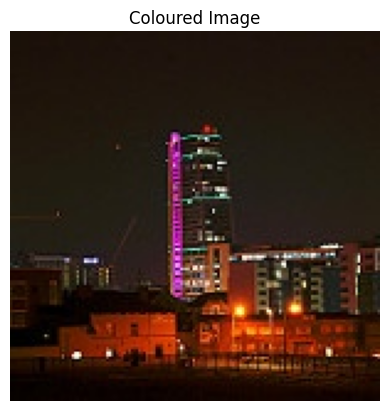

In [ ]:
color_images_path = '/content/unzipped_folder/landscape Images/color/' # Added a trailing slash here
color_image_paths = os.listdir(color_images_path)
random_image_path = os.path.join(color_images_path, color_image_paths[np.random.randint(len(color_image_paths))]) # using os.path.join to create the full path
plt.imshow(plt.imread(random_image_path))
plt.axis('off')
plt.title("Coloured Image")
plt.show()

### 2.2 Explore Grayscale Images
Similarly, let's look at a grayscale image from our dataset.

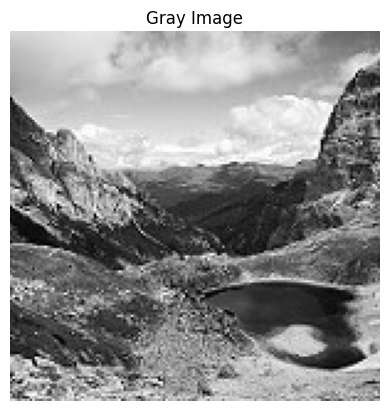

In [ ]:
gray_images_path = '/content/unzipped_folder/landscape Images/gray/' # Added a trailing slash
gray_image_paths = os.listdir(gray_images_path)
random_image_path = os.path.join(gray_images_path, gray_image_paths[np.random.randint(len(gray_image_paths))]) # using os.path.join to construct the path
plt.imshow(plt.imread(random_image_path),cmap='gray')
plt.axis('off')
plt.title("Gray Image")
plt.show()

### 2.3 Compare Grayscale and Color Images
Let's visualize several grayscale and their corresponding color images side by side to better understand our task.

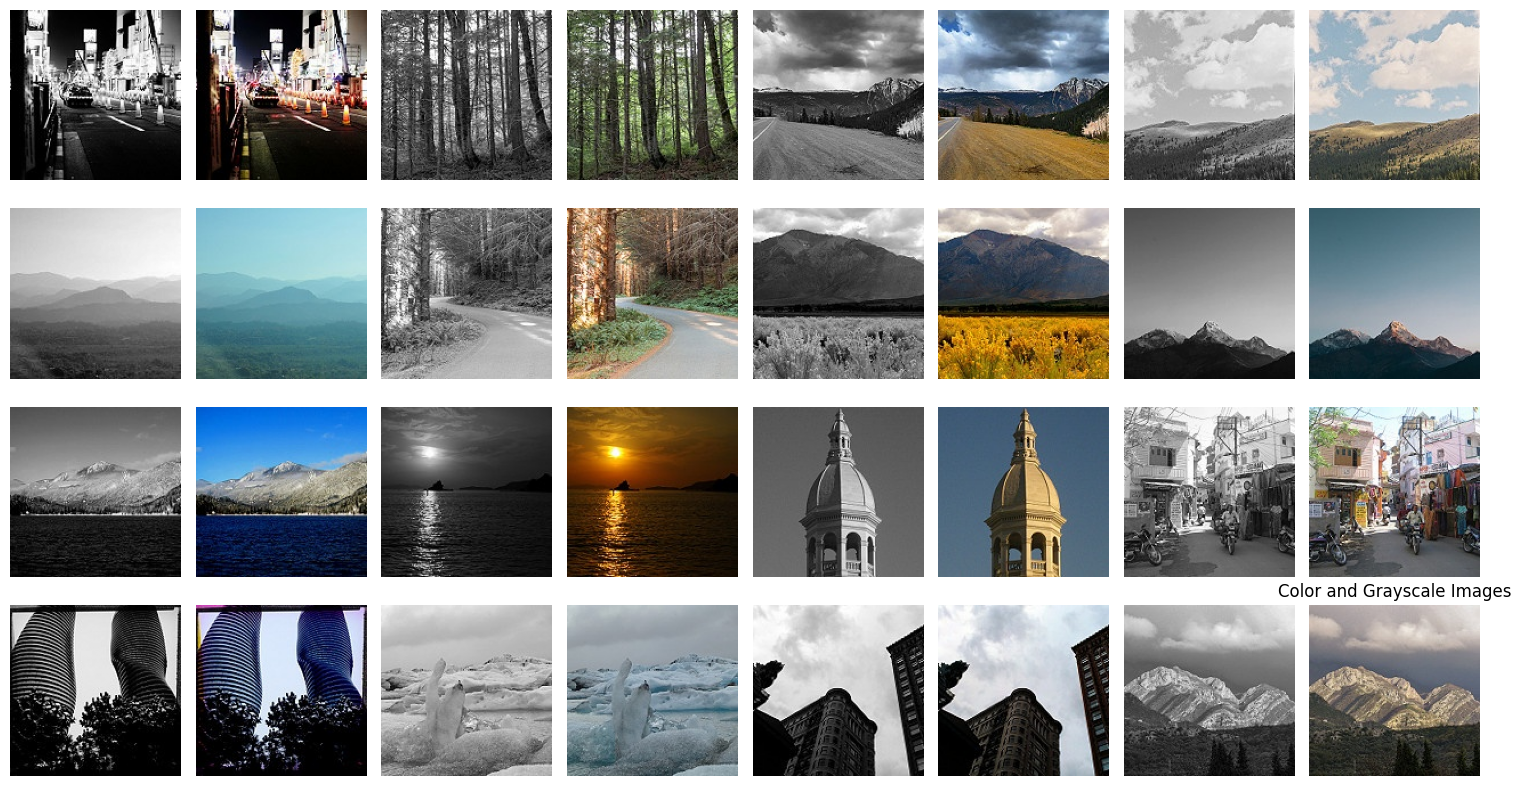

In [ ]:
plt.figure(figsize=(15,20))
n = 1
for i in range(1,33):
    if n == 1:
        image_idx = np.random.randint(len(color_image_paths))
        n += 1
    else: n = 1
    plt.subplot(10,8,i)

    if i%2 == 0:
        plt.imshow(plt.imread(color_images_path + color_image_paths[image_idx]))
        plt.axis('off')
    else:
        plt.imshow(plt.imread(gray_images_path + gray_image_paths[image_idx]),cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.title("Color and Grayscale Images")
plt.show()

## 3. Data Preprocessing

### 3.1 Load and Preprocess Images
We'll load both color and grayscale images, resize them to a consistent size (120x120), and normalize pixel values to the range [0,1].

In [ ]:
color_images = []
gray_images = []
IMG_SIZE = 120
for image_path in color_image_paths:
    img = cv2.cvtColor(cv2.imread(color_images_path + image_path),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE),cv2.INTER_CUBIC)
    img = img.astype('float32')/255.0
    color_images.append(img_to_array(img))


for image_path in gray_image_paths:
    img = cv2.imread(gray_images_path + image_path)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE),cv2.INTER_CUBIC)
    img = img.astype('float32')/255.0
    gray_images.append(img_to_array(img))

### 3.2 Split Data into Training and Testing Sets
We'll use the first 5000 images for training and the rest for testing our model.

In [ ]:
X_train, Y_train = color_images[:5000], gray_images[:5000]
X_test, Y_test = color_images[5000:], gray_images[5000:]

### 3.3 Reshape Data for Model Input
Ensure our data has the right shape for the neural network model.

In [ ]:
%%time
with tf.device('/GPU:0'):
    gray = np.reshape(Y_train,(len(Y_train),IMG_SIZE,IMG_SIZE,3))
    color = np.reshape(X_train, (len(X_train),IMG_SIZE,IMG_SIZE,3))
    print('Train color image shape:',color.shape)

    test_gray = np.reshape(Y_test,(len(Y_test),IMG_SIZE,IMG_SIZE,3))
    test_color = np.reshape(X_test, (len(X_test),IMG_SIZE,IMG_SIZE,3))
    print('Valid color image shape:',test_color.shape)

Train color image shape: (5000, 120, 120, 3)
Valid color image shape: (2129, 120, 120, 3)
CPU times: user 325 ms, sys: 609 ms, total: 934 ms
Wall time: 962 ms


## 4. Model Architecture

### 4.1 Encoder Network
The encoder compresses the input grayscale image into a latent representation using convolutional layers and downsampling.

In [ ]:
%%time
with tf.device('/GPU:0'):
    Encoder = Sequential([
      InputLayer(input_shape=(120,120,3),name="Input_layer"),
      BatchNormalization(),
      Conv2D(64,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_01"),
      BatchNormalization(),
      MaxPooling2D(),
      Conv2D(128,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_02"),
      BatchNormalization(),
      MaxPooling2D(),
      Conv2D(256,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_03"),
      BatchNormalization(),
      MaxPooling2D(),
      Conv2D(512,kernel_size=3,padding='same',activation='relu',kernel_initializer='lecun_normal',name="Conv_04"),
      BatchNormalization(),
      MaxPooling2D(),
  ])

CPU times: user 1.24 s, sys: 60.5 ms, total: 1.3 s
Wall time: 2.91 s


### 4.2 Decoder Network
The decoder reconstructs the color image from the latent representation using transposed convolutions (deconvolutions) for upsampling.

In [ ]:
%%time
with tf.device('/GPU:0'):
    Decoder = Sequential([
      InputLayer(input_shape=(Encoder.output_shape[-3:]),name='Decoder_input'),
      BatchNormalization(),
      Conv2DTranspose(256,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_initializer='lecun_normal',name='ConvT_01'),
      BatchNormalization(),
      Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='lecun_normal',name='ConvT_02'),
      BatchNormalization(),
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='lecun_normal',name='ConvT_03'),
      BatchNormalization(),
      Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',activation='relu',kernel_initializer='glorot_normal',name='ConvT_04'),
      Reshape([120,120,3])
  ])


CPU times: user 79.8 ms, sys: 599 µs, total: 80.4 ms
Wall time: 119 ms


## 5. Model Training

### 5.1 Compile and Train the Autoencoder
We'll combine the encoder and decoder to create an autoencoder model, then train it to convert grayscale images to color.

In [ ]:
# %%time
# with tf.device('/GPU:0'):
#     AutoEncoder = Sequential([Encoder, Decoder])
#     AutoEncoder.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics= ['accuracy'])
#     earlystop = [EarlyStopping(patience=3,restore_best_weights=True)]
#     history = AutoEncoder.fit(gray, color, epochs = 25, verbose=0,validation_data = (test_gray, test_color), batch_size = 12, callbacks = earlystop)

CPU times: user 1min 29s, sys: 12.7 s, total: 1min 41s
Wall time: 4min 15s


In [ ]:
%%time
with tf.device('/GPU:0'):
    # Create learning rate scheduler for better convergence
    def lr_schedule(epoch, lr):
        # Reduce learning rate by 20% every 5 epochs
        if epoch > 0 and epoch % 5 == 0:
            return lr * 0.8
        return lr

    # Use a smaller initial learning rate for better convergence
    initial_learning_rate = 0.0005

    # Compile the autoencoder with improved optimizer settings
    AutoEncoder = Sequential([Encoder, Decoder])
    AutoEncoder.compile(
        loss='mse',  # Mean squared error loss
        optimizer=Adam(
            learning_rate=initial_learning_rate,
            beta_1=0.9,        # Default momentum parameter
            beta_2=0.999,      # Default RMSprop parameter
            epsilon=1e-07,     # Small constant for numerical stability
            amsgrad=True       # Enable AMSGrad variant for better convergence
        ),
        metrics=['accuracy', 'mae']  # Track both accuracy and mean absolute error
    )

    # Set up improved callbacks
    callbacks = [
        # Early stopping with increased patience
        EarlyStopping(
            monitor='val_loss',
            patience=8,               # Increased patience for better convergence
            restore_best_weights=True,
            verbose=1                 # Show early stopping messages
        ),
        # Learning rate scheduler
        tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1),
        # Model checkpointing to save best model
        tf.keras.callbacks.ModelCheckpoint(
            'best_autoencoder_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        # Reduce learning rate on plateau for fine-tuning
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,               # Reduce by half
            patience=3,               # Wait 3 epochs for improvement
            min_lr=0.00001,           # Minimum learning rate
            verbose=1
        )
    ]

    # Train with improved parameters
    history = AutoEncoder.fit(
        gray,                         # Input grayscale images
        color,                        # Target color images
        epochs=40,                    # Increase epochs for better training
        batch_size=16,                # Slightly larger batch size for stable gradients
        validation_data=(test_gray, test_color),
        verbose=1,                    # Show progress during training
        callbacks=callbacks,
        shuffle=True                  # Shuffle data between epochs
    )

    # Save the final model
    AutoEncoder.save('final_autoencoder.h5')


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5269 - loss: 0.0137 - mae: 0.0862
Epoch 1: val_loss improved from inf to 0.01304, saving model to best_autoencoder_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.5269 - loss: 0.0137 - mae: 0.0862 - val_accuracy: 0.5162 - val_loss: 0.0130 - val_mae: 0.0808 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/40
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5388 - loss: 0.0131 - mae: 0.0839
Epoch 2: val_loss improved from 0.01304 to 0.01235, saving model to best_autoencoder_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.5388 - loss: 0.0131 - mae: 0.0839 - val_accuracy: 0.5439 - val_loss: 0.0124 - val_mae: 0.0791 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/40
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5513 - loss: 0.0130 - mae: 0.0836
Epoch 3: val_loss improved from 0.01235 to 0.01222, saving model to best_autoencoder_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.5512 - loss: 0.0130 - mae: 0.0836 - val_accuracy: 0.5493 - val_loss: 0.0122 - val_mae: 0.0785 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5545 - loss: 0.0127 - mae: 0.0826
Epoch 4: val_loss improved from 0.01222 to 0.01217, saving model to best_autoencoder_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5545 - loss: 0.0127 - mae: 0.0826 - val_accuracy: 0.5685 - val_loss: 0.0122 - val_mae: 0.0789 - learning_rate: 5.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5531 - loss: 0.0124 - mae: 0.0815
Epoch 5: val_loss improved from 0.01217 to 0.01169, saving model to best_autoencoder_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.5531 - loss: 0.0124 - mae: 0.0815 - val_accuracy: 0.5625 - val_loss: 0.0117 - val_mae: 0.0756 - learning_rate: 5.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0004000000189989805.
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5537 - loss: 0.0121 - mae: 0.0802
Epoch 6: val_loss improved from 0.01169 to 0.01166, saving model to best_autoencoder_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.5538 - loss: 0.0121 - mae: 0.0802 - val_accuracy: 0.5754 - val_loss: 0.0117 - val_mae: 0.0759 - learning_rate: 4.0000e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0004000000189989805.
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5603 - loss: 0.0120 - mae: 0.0800
Epoch 7: val_loss did not improve from 0.01166
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5603 - loss: 0.0120 - mae: 0.0800 - val_accuracy: 0.5851 - val_loss: 0.0121 - val_mae: 0.0783 - learning_rate: 4.0000e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004000000189989805.
Epoch 8/40
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5627 - loss: 0.0128 - mae: 0.0826
Epoch 8: val_loss did not improve from 0.01166

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5626 - loss: 0.0128 - mae: 0.0827 - val_accuracy: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.5705 - loss: 0.0116 - mae: 0.0786 - val_accuracy: 0.5743 - val_loss: 0.0117 - val_mae: 0.0757 - learning_rate: 8.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 8.000000525498763e-05.
Epoch 14/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5792 - loss: 0.0114 - mae: 0.0778
Epoch 14: val_loss improved from 0.01165 to 0.01165, saving model to best_autoencoder_model.h5



Epoch 14: ReduceLROnPlateau reducing learning rate to 4.0000002627493814e-05.
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.5792 - loss: 0.0114 - mae: 0.0778 - val_accuracy: 0.5688 - val_loss: 0.0117 - val_mae: 0.0757 - learning_rate: 8.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 4.0000002627493814e-05.
Epoch 15/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5835 - loss: 0.0113 - mae: 0.0769
Epoch 15: val_loss did not improve from 0.01165
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5835 - loss: 0.0113 - mae: 0.0769 - val_accuracy: 0.5690 - val_loss: 0.0118 - val_mae: 0.0757 - learning_rate: 4.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 3.200000210199505e-05.
Epoch 16/40
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5781 - loss: 0.0114 - mae: 0.0776
Epoch 16: val_loss did not improve from 0.01165
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.5781 - loss: 0.0114 - mae: 0.0776 - val_acc

CPU times: user 2min 20s, sys: 16.3 s, total: 2min 36s
Wall time: 7min 9s


## 6. Model Evaluation

### 6.1 Evaluate Training Performance
Let's visualize the model's accuracy during training to assess its performance.

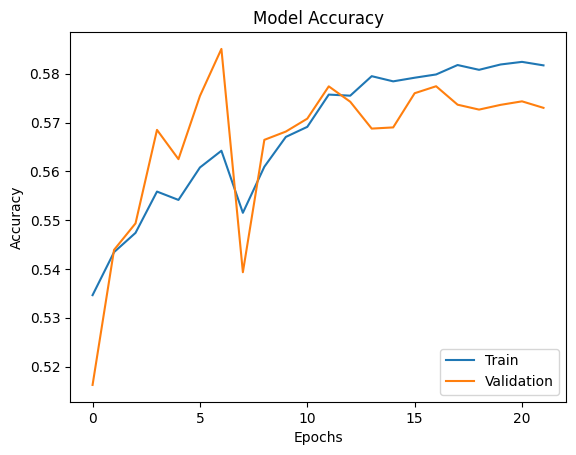

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

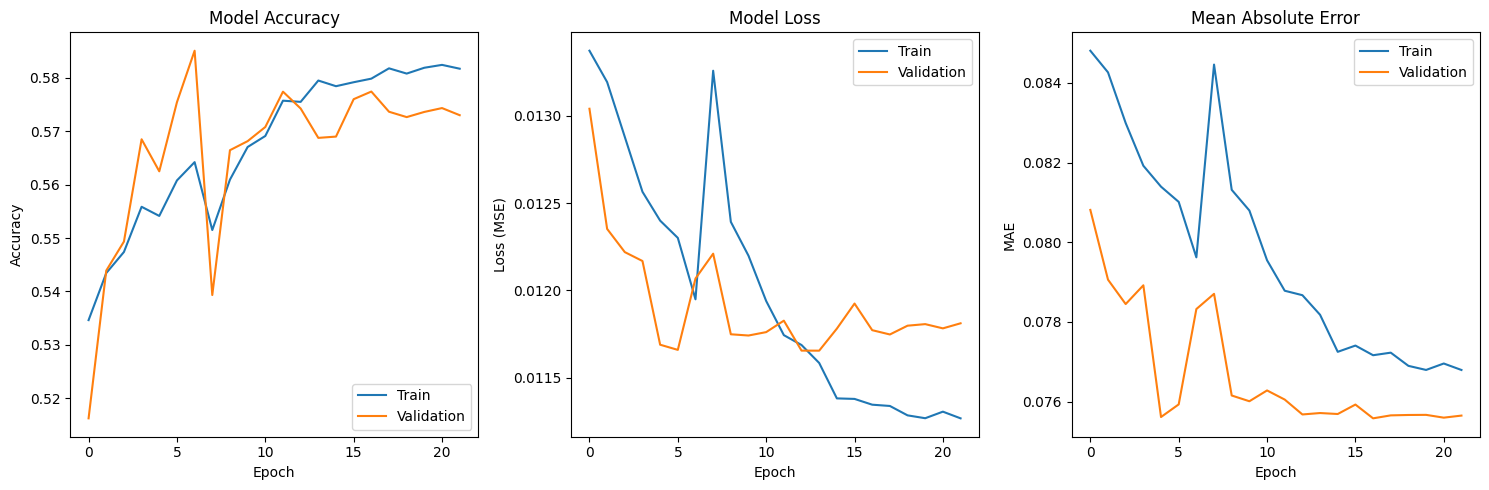

In [ ]:
# Plot the training and validation metrics
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE
plt.subplot(1, 3, 3)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


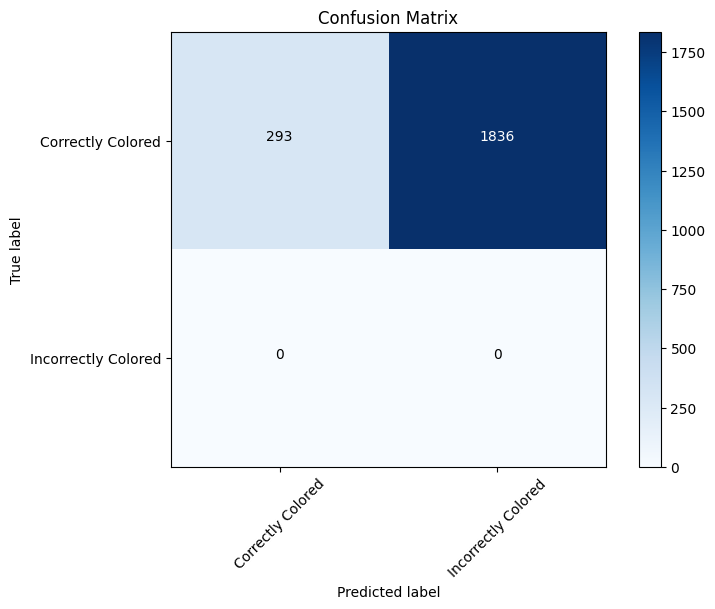

'              precision    recall  f1-score   support\n\n           0       1.00      0.14      0.24      2129\n           1       0.00      0.00      0.00         0\n\n    accuracy                           0.14      2129\n   macro avg       0.50      0.07      0.12      2129\nweighted avg       1.00      0.14      0.24      2129\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'AutoEncoder' is your trained model and 'test_gray' and 'test_color' are your test data
# Get predictions
predictions = AutoEncoder.predict(test_gray)

# For simplicity, we'll consider a binary classification based on the difference between the prediction and actual images
# We can define a threshold and compare Mean Absolute Error (MAE) between the images.
threshold = 0.1  # Choose your threshold
predicted_labels = (np.mean(np.abs(predictions - test_color), axis=(1, 2, 3)) < threshold).astype(int)
true_labels = np.zeros_like(predicted_labels) # In this case, we are assuming that everything is considered 'correctly colored'

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate classification report
report = classification_report(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2) # Number of classes
plt.xticks(tick_marks, ['Correctly Colored', 'Incorrectly Colored'], rotation=45)
plt.yticks(tick_marks, ['Correctly Colored', 'Incorrectly Colored'])

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report
report


### 6.2 Visualize Colorization Results
Let's compare the original grayscale images with our model's colorized outputs and the real color images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


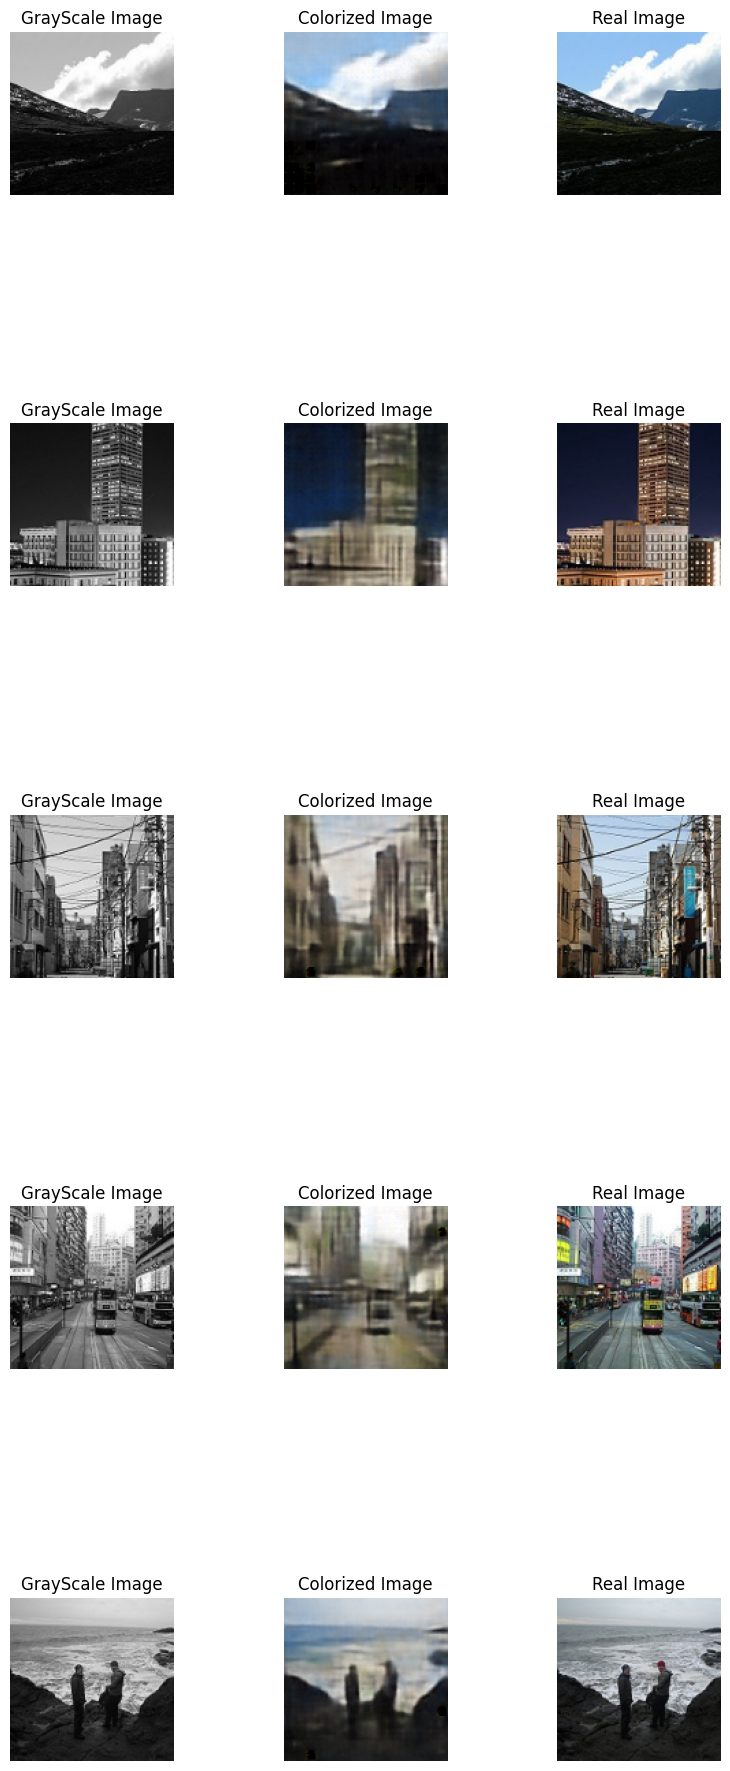

In [ ]:
plt.figure(figsize=(10,25))
for i in range(1,30,6):
    rand_idx = np.random.randint(5000)

    color_imgs = X_train[rand_idx]
    gray_imgs = Y_train[rand_idx]
    colorized_img = AutoEncoder.predict(gray_imgs[np.newaxis,...])[0]

    plt.subplot(10,3,i)
    plt.title("GrayScale Image")
    plt.imshow(gray_imgs)
    plt.axis('off')

    plt.subplot(10,3,i+1)
    plt.title("Colorized Image")
    plt.imshow(colorized_img)
    plt.axis('off')

    plt.subplot(10,3,i+2)
    plt.title("Real Image")
    plt.imshow(color_imgs)
    plt.axis('off')


## 7. Conclusion

In this project, we successfully built and trained an autoencoder model for automatic image colorization. The model learns to map grayscale images to their colored versions by capturing the underlying patterns and features.

### Key Achievements:
- Developed an encoder-decoder architecture using convolutional neural networks
- Trained the model on a dataset of landscape images
- Generated colorized versions of grayscale images with reasonable quality

### Potential Improvements:
- Experiment with more complex architectures like U-Net or ResNet
- Use perceptual loss functions that better capture human visual perception
- Apply data augmentation to increase training variety
- Try adding attention mechanisms to focus on important image regions